### COMP0082 Coursework V2.02
##### Predicting the subcellular location of proteins

**Goal** : develop a simple method for classifying eukaryotic protein sequences into the 5 categories
* Cytosolic - i.e. within the cell itself, but not inside any organelles

* Extracellular/Secreted - proteins which are transported out of a cell

* Nuclear - proteins found/used within the cell's nucleus

* Mitochondrial - proteins transported to the cell's mitochondria

* Other - none of the above

---

### Task 1: Dataset description

In [103]:
!pip install Bio

In [104]:
# Load the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from Bio import SeqIO

---

Load the FASTA files

SeqIO.parse from Biopython is an efficient way to read and process FASTA files when preparing data for training a machine learning model for the classification of subcellular localization of proteins. The SeqIO.parse function returns SeqRecord objects, which include attributes such as id, name, description, and seq. These attributes help organize and access the sequence data and metadata in a structured manner.

In [105]:
# Load the data
from Bio import SeqIO
import os

def load_fasta_file_assign_class(fasta_file_path, print_data=False):

    label = os.path.splitext(os.path.basename(fasta_file_path))[0]  # Get filename without extension

    if label == 'cyto':
        label = 'Cyto'
    if label == 'secreted':
        label = 'Extr'
    if label == 'mito':
        label = 'Mito'
    if label == 'nucleus':
        label = 'Nucl'
    if label == 'other':
        label = 'Othr'

    # Parse the FASTA file
    records = SeqIO.parse(fasta_file_path, "fasta")
    sequences = []

    for record in records:
    # You can store the sequence and the label together in a tuple or dictionary
        sequences.append((record.seq, label))  # Here, we're storing the sequence and the label as a tuple

        if print_data:
            print("Printing the record:")
            print(record)
            print("Printing the sequence:")
            print(record.seq)
            print("Printing the label:")
            print(label)

    # Assign a label to each sequence based on the file it came from
    # records = [(record.id, record.seq) for record in SeqIO.parse(fasta_file_path, "fasta")]

    return sequences

In [106]:
cyto_records = load_fasta_file_assign_class ("cyto.fasta")

In [107]:
secreted_records = load_fasta_file_assign_class("secreted.fasta")

In [108]:
mito_records = load_fasta_file_assign_class("mito.fasta")

In [109]:
nucleus_records = load_fasta_file_assign_class("nucleus.fasta")

In [110]:
other_records = load_fasta_file_assign_class("other.fasta")

---

#### 1.1 Basic statics and feature extraction

Distribution of labels

In [111]:
from collections import Counter

# Distribution of label classes
def class_counter(records):
    # Extract labels from the records
    labels = [label for _, label in records]

    # Compute the label distribution
    label_counter = Counter(labels)

    return label_counter

# The separation of classes is given by the separation of fasta files

cyto_class_numbers = class_counter(cyto_records)
secreted_class_numbers = class_counter(secreted_records)
mito_class_numbers = class_counter(mito_records)
nucleus_class_numbers = class_counter(nucleus_records)
other_class_numbers = class_counter(other_records)

In [112]:
# Test
print("Number of cyto classes: ", cyto_class_numbers)
sum(cyto_class_numbers.values())

Number of cyto classes:  Counter({'Cyto': 2463})


2463

Plot the class distribution

In [113]:
import matplotlib.pyplot as plt

# Combine the class counts into a single dictionary
class_counts = {
    'cyto': sum(cyto_class_numbers.values()),
    'secreted': sum(secreted_class_numbers.values()),
    'mito': sum(mito_class_numbers.values()),
    'nucleus': sum(nucleus_class_numbers.values()),
    'none of the above': sum(other_class_numbers.values())
}

# Extract labels and their counts
labels, counts = zip(*class_counts.items())

print("Labels: ", labels)
print("Counts: ", counts)

Labels:  ('cyto', 'secreted', 'mito', 'nucleus', 'none of the above')
Counts:  (2463, 1236, 1023, 2736, 2002)


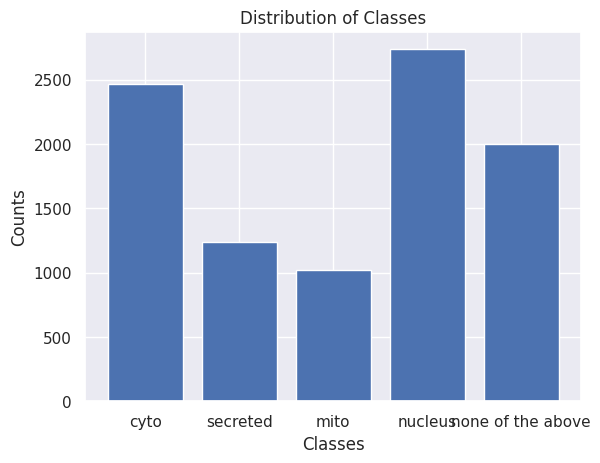

In [114]:
# Create a bar chart
plt.bar(labels, counts)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribution of Classes')
plt.show()

---

In [115]:
# Aminoacid freq
def amino_acid_frequencies(seq):
    # Define the amino acids
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"

    seq_length = len(seq)

    # Calculate the frequency of each amino acid
    aa_freq = {aa: seq.count(aa) / seq_length for aa in amino_acids}

    return aa_freq  # Return the frequency dictionary directly


In [116]:
# Base Composition (GC/AT content)
def sequence_length_at_gc_content(seq):


    # Calculate the sequence length
    seq_length = len(seq)

    # Calculate the GC content
    gc_content = (seq.count("G") + seq.count("C")) / seq_length

    # Calculate the AT content
    at_content = (seq.count("A") + seq.count("T")) / seq_length

    return gc_content, at_content

In [117]:
# Not amino-acids
def non_amino_acids(records):
  # Define allowed amino acids
  allowed_chars = set("ACDEFGHIKLMNPQRSTVWY")

  for seq, label in records:
      # Check for invalid characters in the sequence
      invalid_chars = set(seq) - allowed_chars
      if invalid_chars:
          print(f"Invalid characters in sequence {label}: {invalid_chars}")

In [118]:
non_amino_acids(cyto_records)
non_amino_acids(secreted_records)
non_amino_acids(mito_records)
non_amino_acids(nucleus_records)
non_amino_acids(other_records)

Invalid characters in sequence Cyto: {'X'}
Invalid characters in sequence Cyto: {'U'}
Invalid characters in sequence Cyto: {'U'}
Invalid characters in sequence Cyto: {'U'}
Invalid characters in sequence Cyto: {'U'}
Invalid characters in sequence Cyto: {'U'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'B'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid characters in sequence Extr: {'X'}
Invalid cha

In [119]:
# Sequences with Only One Amino Acid
def seq_with_one_amino(records):
  # Define allowed amino acids

  for seq, label in records:
      if len(set(seq)) == 1:  # Check if the sequence consists of a single amino acid
          print(f"Sequence {label} is made of a single amino acid: {seq}")


In [120]:
# TEST
seq_with_one_amino(cyto_records)
seq_with_one_amino(secreted_records)
seq_with_one_amino(mito_records)
seq_with_one_amino(nucleus_records)

---

Assembly dataset

In [121]:
!pip install Bio

In [122]:
!pip install biopython --upgrade

In [123]:
import Bio
print(Bio.__version__)

1.85


In [124]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [125]:
!pip install ProtParam

ERROR: Could not find a version that satisfies the requirement ProtParam (from versions: none)
ERROR: No matching distribution found for ProtParam


In [126]:
from Bio.SeqUtils import ProtParam
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import molecular_weight
from Bio.SeqUtils.ProtParam import ProtParamData
from Bio.SeqUtils.ProtParam import ProteinAnalysis
# from Bio.SeqUtils.ProtParam import aromaticity  # Import aromaticity from the correct location
from Bio.PDB.Polypeptide import PPBuilder # flexibility moved here


In [127]:
datasets = [cyto_records, secreted_records, mito_records, nucleus_records, other_records]
eukaryotic_data = []

# All refernces https://biopython.org/wiki/ProtParam
for dataset in datasets:
    for record in dataset:
        seq, label = record
        seq = seq.replace('X', '').replace('U', '').replace('B', '')
        #Explain your choices, giving references.

        features = {
            'label': label,
            'sequence_length': len(seq),
            'sequence': str(seq),
            'molecular_weight': ProteinAnalysis(str(seq)).molecular_weight(),
            'isoelectric_point': ProteinAnalysis(str(seq)).isoelectric_point(),
            'charge_distribution': ProteinAnalysis(str(seq)).charge_at_pH(7.4),
            'aromaticity': ProteinAnalysis(str(seq)).aromaticity(),
            'flexibility': ProteinAnalysis(str(seq)).flexibility(), # check ref https://onlinelibrary.wiley.com/doi/abs/10.1002/prot.340190203
            'secondary_structure_fraction': ProteinAnalysis(str(seq)).secondary_structure_fraction(),
            'hydropathy_index': ProtParam.ProteinAnalysis(str(seq)).gravy(),
            'charge_to_isoelectric_point_ratio': ProteinAnalysis(str(seq)).charge_at_pH(7.4) / ProteinAnalysis(str(seq)).isoelectric_point(),
            'molecular_weight_per_length' : ProteinAnalysis(str(seq)).molecular_weight() / len(seq)
            }

        # Amino acid frequency features
        aa_frequencies = amino_acid_frequencies(seq)
        for aa, freq in aa_frequencies.items():
          features[f'{aa}_freq'] = freq

        # GC content
        gc_content, at_content = sequence_length_at_gc_content(seq)
        features['gc_content'] = gc_content
        features['at_content'] = at_content


        eukaryotic_data.append(features)

---

Create the dataset

In [128]:
import pandas as pd

# Assuming eukaryotic_data is your list of dictionaries
eukaryotic_df = pd.DataFrame(eukaryotic_data)

# Display the first few rows of the DataFrame
eukaryotic_df.head()

,label,sequence_length,sequence,molecular_weight,isoelectric_point,charge_distribution,aromaticity,flexibility,secondary_structure_fraction,hydropathy_index,charge_to_isoelectric_point_ratio,molecular_weight_per_length,A_freq,C_freq,D_freq,E_freq,F_freq,G_freq,H_freq,I_freq,K_freq,L_freq,M_freq,N_freq,P_freq,Q_freq,R_freq,S_freq,T_freq,V_freq,W_freq,Y_freq,gc_content,at_content
0,Cyto,885,MGEGALAPGLQLLLRACEQGDTDTARRLLEPGGEPVAGSEAGAEPA...,93807.5675,7.725465,1.081741,0.035028,"[0.9975000000000003, 1.0103214285714286, 1.012...","(0.33107344632768365, 0.36610169491525424, 0.2...",-0.452542,0.140023,105.997251,0.098305,0.010169,0.051977,0.054237,0.018079,0.093785,0.032768,0.018079,0.046328,0.109605,0.022599,0.036158,0.080226,0.036158,0.061017,0.103955,0.051977,0.057627,0.010169,0.006780,0.103955,0.150282
1,Cyto,543,MLVKPMACYFEIWTRKVTTIEDFSLAIANRFKQMGSHSDSEVDWDN...,61760.1822,4.779614,-28.742909,0.106814,"[0.9701785714285714, 0.984202380952381, 0.9601...","(0.2928176795580111, 0.292817679558011, 0.3848...",-0.288029,-6.013647,113.738825,0.053407,0.023941,0.086556,0.064457,0.058932,0.046041,0.018416,0.060773,0.068140,0.081031,0.025783,0.053407,0.033149,0.036832,0.031308,0.073665,0.064457,0.071823,0.016575,0.031308,0.069982,0.117864
2,Cyto,390,MPPKQHRHQKKDKNDNALQNTIGFVPPGATLASVSGYRPPDAFVNR...,44025.7431,6.070313,-7.336220,0.076923,"[1.004702380952381, 1.0290357142857143, 1.008,...","(0.3128205128205128, 0.3025641025641026, 0.341...",-0.386923,-1.208541,112.886521,0.061538,0.010256,0.061538,0.066667,0.043590,0.056410,0.035897,0.041026,0.053846,0.087179,0.043590,0.061538,0.061538,0.028205,0.056410,0.061538,0.053846,0.082051,0.010256,0.023077,0.066667,0.115385
3,Cyto,312,MATSANLDIGAQLIVEECPSSYISGMPDIKLEHQLDPNPDEGAAQG...,34062.1479,5.044768,-16.481346,0.054487,"[1.0141666666666669, 0.9830357142857141, 1.025...","(0.3333333333333333, 0.3076923076923077, 0.336...",-0.225962,-3.267018,109.173551,0.080128,0.019231,0.054487,0.067308,0.022436,0.070513,0.035256,0.051282,0.044872,0.108974,0.032051,0.064103,0.044872,0.051282,0.025641,0.073718,0.054487,0.067308,0.006410,0.025641,0.089744,0.134615
4,Cyto,469,MEQIQMVKVLEKCQVTPPSDTTDVELSLPVTFFDIPWLHLNKMQSL...,52739.1110,5.568198,-10.623923,0.108742,"[0.9790833333333333, 0.9840714285714286, 1.018...","(0.31769722814498935, 0.2899786780383795, 0.39...",-0.059701,-1.907964,112.450130,0.059701,0.017058,0.066098,0.057569,0.061834,0.055437,0.021322,0.055437,0.070362,0.102345,0.027719,0.038380,0.053305,0.025586,0.031983,0.076759,0.053305,0.078891,0.012793,0.034115,0.072495,0.113006


---

In [129]:
# Transform flexibility list function, to have values suitable for the model
def compute_flexibility_stats(flex_list):
  if not flex_list:  # Check if the list is empty
    return pd.Series({'min_flex': np.nan, 'max_flex': np.nan, 'mean_flex': np.nan, 'std_flex': np.nan})
  else:
    return pd.Series({
        'min_flex': np.min(flex_list),
        'max_flex': np.max(flex_list),
        'mean_flex': np.mean(flex_list),
        'std_flex': np.std(flex_list)
    })

In [130]:
flexibility_stats = eukaryotic_df['flexibility'].apply(compute_flexibility_stats)

In [131]:
print(flexibility_stats)

      min_flex  max_flex  mean_flex  std_flex
0     0.943560  1.070702   1.007633  0.024921
1     0.933298  1.070012   1.000876  0.027829
2     0.944798  1.077512   1.000768  0.025313
3     0.935560  1.068440   1.001166  0.025129
4     0.933429  1.068048   0.997805  0.027371
...        ...       ...        ...       ...
9455  0.939548  1.058595   1.005229  0.021396
9456  0.939833  1.059250   1.000739  0.023866
9457  0.940940  1.052667   0.992008  0.022223
9458  0.935857  1.048679   0.996738  0.022363
9459  0.947083  1.055179   0.998091  0.023099

[9460 rows x 4 columns]


In [132]:
eukaryotic_df = pd.concat([eukaryotic_df, flexibility_stats], axis=1)

In [133]:
display(eukaryotic_df.head())

,label,sequence_length,sequence,molecular_weight,isoelectric_point,charge_distribution,aromaticity,flexibility,secondary_structure_fraction,hydropathy_index,charge_to_isoelectric_point_ratio,molecular_weight_per_length,A_freq,C_freq,D_freq,E_freq,F_freq,G_freq,H_freq,I_freq,K_freq,L_freq,M_freq,N_freq,P_freq,Q_freq,R_freq,S_freq,T_freq,V_freq,W_freq,Y_freq,gc_content,at_content,min_flex,max_flex,mean_flex,std_flex
0,Cyto,885,MGEGALAPGLQLLLRACEQGDTDTARRLLEPGGEPVAGSEAGAEPA...,93807.5675,7.725465,1.081741,0.035028,"[0.9975000000000003, 1.0103214285714286, 1.012...","(0.33107344632768365, 0.36610169491525424, 0.2...",-0.452542,0.140023,105.997251,0.098305,0.010169,0.051977,0.054237,0.018079,0.093785,0.032768,0.018079,0.046328,0.109605,0.022599,0.036158,0.080226,0.036158,0.061017,0.103955,0.051977,0.057627,0.010169,0.006780,0.103955,0.150282,0.943560,1.070702,1.007633,0.024921
1,Cyto,543,MLVKPMACYFEIWTRKVTTIEDFSLAIANRFKQMGSHSDSEVDWDN...,61760.1822,4.779614,-28.742909,0.106814,"[0.9701785714285714, 0.984202380952381, 0.9601...","(0.2928176795580111, 0.292817679558011, 0.3848...",-0.288029,-6.013647,113.738825,0.053407,0.023941,0.086556,0.064457,0.058932,0.046041,0.018416,0.060773,0.068140,0.081031,0.025783,0.053407,0.033149,0.036832,0.031308,0.073665,0.064457,0.071823,0.016575,0.031308,0.069982,0.117864,0.933298,1.070012,1.000876,0.027829
2,Cyto,390,MPPKQHRHQKKDKNDNALQNTIGFVPPGATLASVSGYRPPDAFVNR...,44025.7431,6.070313,-7.336220,0.076923,"[1.004702380952381, 1.0290357142857143, 1.008,...","(0.3128205128205128, 0.3025641025641026, 0.341...",-0.386923,-1.208541,112.886521,0.061538,0.010256,0.061538,0.066667,0.043590,0.056410,0.035897,0.041026,0.053846,0.087179,0.043590,0.061538,0.061538,0.028205,0.056410,0.061538,0.053846,0.082051,0.010256,0.023077,0.066667,0.115385,0.944798,1.077512,1.000768,0.025313
3,Cyto,312,MATSANLDIGAQLIVEECPSSYISGMPDIKLEHQLDPNPDEGAAQG...,34062.1479,5.044768,-16.481346,0.054487,"[1.0141666666666669, 0.9830357142857141, 1.025...","(0.3333333333333333, 0.3076923076923077, 0.336...",-0.225962,-3.267018,109.173551,0.080128,0.019231,0.054487,0.067308,0.022436,0.070513,0.035256,0.051282,0.044872,0.108974,0.032051,0.064103,0.044872,0.051282,0.025641,0.073718,0.054487,0.067308,0.006410,0.025641,0.089744,0.134615,0.935560,1.068440,1.001166,0.025129
4,Cyto,469,MEQIQMVKVLEKCQVTPPSDTTDVELSLPVTFFDIPWLHLNKMQSL...,52739.1110,5.568198,-10.623923,0.108742,"[0.9790833333333333, 0.9840714285714286, 1.018...","(0.31769722814498935, 0.2899786780383795, 0.39...",-0.059701,-1.907964,112.450130,0.059701,0.017058,0.066098,0.057569,0.061834,0.055437,0.021322,0.055437,0.070362,0.102345,0.027719,0.038380,0.053305,0.025586,0.031983,0.076759,0.053305,0.078891,0.012793,0.034115,0.072495,0.113006,0.933429,1.068048,0.997805,0.027371


In [134]:
# Drop the flexibility column to When preparing your dataset for machine learning,
# it's generally advisable to remove the original 'flexibility_scores' column after
#creating aggregated features like min_flex, max_flex, mean_flex, and std_flex.
# This practice helps prevent issues such as multicollinearity,
#where features are highly correlated, potentially leading to model instability and reduced performance
eukaryotic_df.drop(columns=['flexibility'], inplace=True)

In [135]:
display(eukaryotic_df.head())

,label,sequence_length,sequence,molecular_weight,isoelectric_point,charge_distribution,aromaticity,secondary_structure_fraction,hydropathy_index,charge_to_isoelectric_point_ratio,molecular_weight_per_length,A_freq,C_freq,D_freq,E_freq,F_freq,G_freq,H_freq,I_freq,K_freq,L_freq,M_freq,N_freq,P_freq,Q_freq,R_freq,S_freq,T_freq,V_freq,W_freq,Y_freq,gc_content,at_content,min_flex,max_flex,mean_flex,std_flex
0,Cyto,885,MGEGALAPGLQLLLRACEQGDTDTARRLLEPGGEPVAGSEAGAEPA...,93807.5675,7.725465,1.081741,0.035028,"(0.33107344632768365, 0.36610169491525424, 0.2...",-0.452542,0.140023,105.997251,0.098305,0.010169,0.051977,0.054237,0.018079,0.093785,0.032768,0.018079,0.046328,0.109605,0.022599,0.036158,0.080226,0.036158,0.061017,0.103955,0.051977,0.057627,0.010169,0.006780,0.103955,0.150282,0.943560,1.070702,1.007633,0.024921
1,Cyto,543,MLVKPMACYFEIWTRKVTTIEDFSLAIANRFKQMGSHSDSEVDWDN...,61760.1822,4.779614,-28.742909,0.106814,"(0.2928176795580111, 0.292817679558011, 0.3848...",-0.288029,-6.013647,113.738825,0.053407,0.023941,0.086556,0.064457,0.058932,0.046041,0.018416,0.060773,0.068140,0.081031,0.025783,0.053407,0.033149,0.036832,0.031308,0.073665,0.064457,0.071823,0.016575,0.031308,0.069982,0.117864,0.933298,1.070012,1.000876,0.027829
2,Cyto,390,MPPKQHRHQKKDKNDNALQNTIGFVPPGATLASVSGYRPPDAFVNR...,44025.7431,6.070313,-7.336220,0.076923,"(0.3128205128205128, 0.3025641025641026, 0.341...",-0.386923,-1.208541,112.886521,0.061538,0.010256,0.061538,0.066667,0.043590,0.056410,0.035897,0.041026,0.053846,0.087179,0.043590,0.061538,0.061538,0.028205,0.056410,0.061538,0.053846,0.082051,0.010256,0.023077,0.066667,0.115385,0.944798,1.077512,1.000768,0.025313
3,Cyto,312,MATSANLDIGAQLIVEECPSSYISGMPDIKLEHQLDPNPDEGAAQG...,34062.1479,5.044768,-16.481346,0.054487,"(0.3333333333333333, 0.3076923076923077, 0.336...",-0.225962,-3.267018,109.173551,0.080128,0.019231,0.054487,0.067308,0.022436,0.070513,0.035256,0.051282,0.044872,0.108974,0.032051,0.064103,0.044872,0.051282,0.025641,0.073718,0.054487,0.067308,0.006410,0.025641,0.089744,0.134615,0.935560,1.068440,1.001166,0.025129
4,Cyto,469,MEQIQMVKVLEKCQVTPPSDTTDVELSLPVTFFDIPWLHLNKMQSL...,52739.1110,5.568198,-10.623923,0.108742,"(0.31769722814498935, 0.2899786780383795, 0.39...",-0.059701,-1.907964,112.450130,0.059701,0.017058,0.066098,0.057569,0.061834,0.055437,0.021322,0.055437,0.070362,0.102345,0.027719,0.038380,0.053305,0.025586,0.031983,0.076759,0.053305,0.078891,0.012793,0.034115,0.072495,0.113006,0.933429,1.068048,0.997805,0.027371


---

In [136]:
# Transform secondary_structure_fraction to feed it into the model
import pandas as pd


# Extracting tuple elements into separate columns
eukaryotic_df[['helix_fraction', 'sheet_fraction', 'coil_fraction']] = pd.DataFrame(eukaryotic_df['secondary_structure_fraction'].tolist(), index=eukaryotic_df.index) # ? paper


# Dropping the original 'secondary_structure_fraction' column if no longer needed
eukaryotic_df.drop(columns=['secondary_structure_fraction'], inplace=True)

In [137]:
# Show all columns in dataframe
pd.set_option('display.max_columns', None)

display(eukaryotic_df.head())
print(eukaryotic_df.shape)

,label,sequence_length,sequence,molecular_weight,isoelectric_point,charge_distribution,aromaticity,hydropathy_index,charge_to_isoelectric_point_ratio,molecular_weight_per_length,A_freq,C_freq,D_freq,E_freq,F_freq,G_freq,H_freq,I_freq,K_freq,L_freq,M_freq,N_freq,P_freq,Q_freq,R_freq,S_freq,T_freq,V_freq,W_freq,Y_freq,gc_content,at_content,min_flex,max_flex,mean_flex,std_flex,helix_fraction,sheet_fraction,coil_fraction
0,Cyto,885,MGEGALAPGLQLLLRACEQGDTDTARRLLEPGGEPVAGSEAGAEPA...,93807.5675,7.725465,1.081741,0.035028,-0.452542,0.140023,105.997251,0.098305,0.010169,0.051977,0.054237,0.018079,0.093785,0.032768,0.018079,0.046328,0.109605,0.022599,0.036158,0.080226,0.036158,0.061017,0.103955,0.051977,0.057627,0.010169,0.006780,0.103955,0.150282,0.943560,1.070702,1.007633,0.024921,0.331073,0.366102,0.272316
1,Cyto,543,MLVKPMACYFEIWTRKVTTIEDFSLAIANRFKQMGSHSDSEVDWDN...,61760.1822,4.779614,-28.742909,0.106814,-0.288029,-6.013647,113.738825,0.053407,0.023941,0.086556,0.064457,0.058932,0.046041,0.018416,0.060773,0.068140,0.081031,0.025783,0.053407,0.033149,0.036832,0.031308,0.073665,0.064457,0.071823,0.016575,0.031308,0.069982,0.117864,0.933298,1.070012,1.000876,0.027829,0.292818,0.292818,0.384899
2,Cyto,390,MPPKQHRHQKKDKNDNALQNTIGFVPPGATLASVSGYRPPDAFVNR...,44025.7431,6.070313,-7.336220,0.076923,-0.386923,-1.208541,112.886521,0.061538,0.010256,0.061538,0.066667,0.043590,0.056410,0.035897,0.041026,0.053846,0.087179,0.043590,0.061538,0.061538,0.028205,0.056410,0.061538,0.053846,0.082051,0.010256,0.023077,0.066667,0.115385,0.944798,1.077512,1.000768,0.025313,0.312821,0.302564,0.341026
3,Cyto,312,MATSANLDIGAQLIVEECPSSYISGMPDIKLEHQLDPNPDEGAAQG...,34062.1479,5.044768,-16.481346,0.054487,-0.225962,-3.267018,109.173551,0.080128,0.019231,0.054487,0.067308,0.022436,0.070513,0.035256,0.051282,0.044872,0.108974,0.032051,0.064103,0.044872,0.051282,0.025641,0.073718,0.054487,0.067308,0.006410,0.025641,0.089744,0.134615,0.935560,1.068440,1.001166,0.025129,0.333333,0.307692,0.336538
4,Cyto,469,MEQIQMVKVLEKCQVTPPSDTTDVELSLPVTFFDIPWLHLNKMQSL...,52739.1110,5.568198,-10.623923,0.108742,-0.059701,-1.907964,112.450130,0.059701,0.017058,0.066098,0.057569,0.061834,0.055437,0.021322,0.055437,0.070362,0.102345,0.027719,0.038380,0.053305,0.025586,0.031983,0.076759,0.053305,0.078891,0.012793,0.034115,0.072495,0.113006,0.933429,1.068048,0.997805,0.027371,0.317697,0.289979,0.398721


(9460, 39)


---

Plots

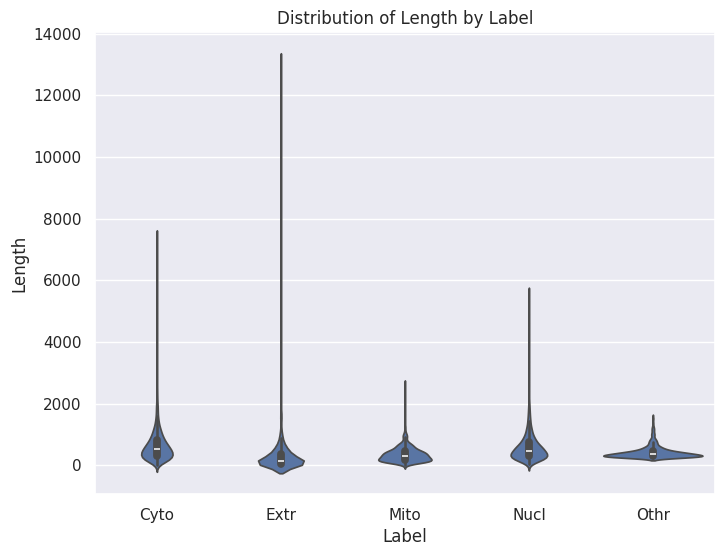

In [138]:
# Distribution of the sequence length for each subcellular location
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")  # Optional: Set the plot style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
sns.violinplot(x='label', y='sequence_length', data=eukaryotic_df)
plt.title('Distribution of Length by Label')
plt.xlabel('Label')
plt.ylabel('Length')
plt.show()

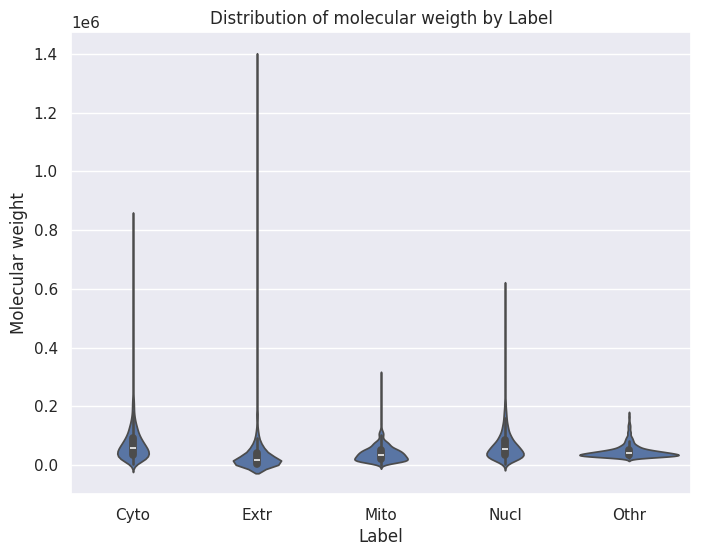

In [139]:
# Distribution of the molecular weight for each subcellular location
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")  # Optional: Set the plot style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
sns.violinplot(x='label', y='molecular_weight', data=eukaryotic_df)
plt.title('Distribution of molecular weigth by Label')
plt.xlabel('Label')
plt.ylabel('Molecular weight')
plt.show()

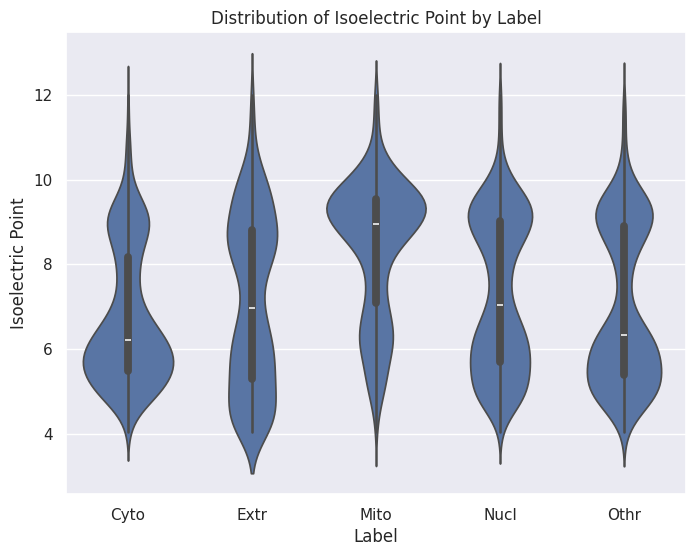

In [140]:
# Distribution of the isoelectric point for each subcellular location

import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")  # Optional: Set the plot style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
sns.violinplot(x='label', y='isoelectric_point', data=eukaryotic_df)
plt.title('Distribution of Isoelectric Point by Label')
plt.xlabel('Label')
plt.ylabel('Isoelectric Point')
plt.show()

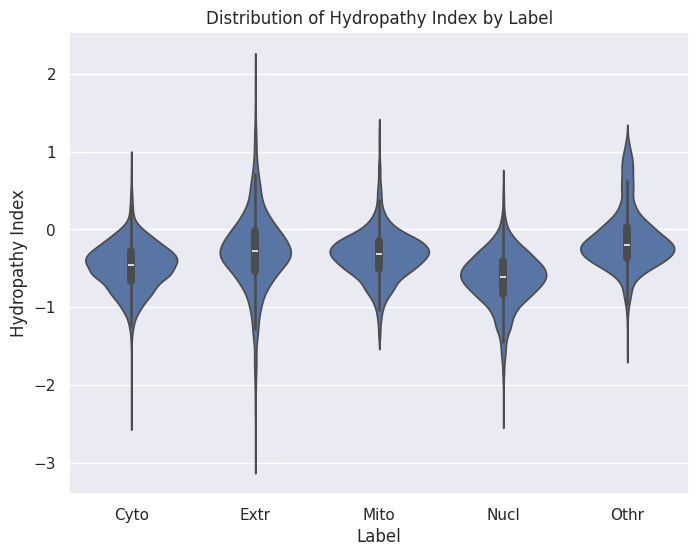

In [141]:
# Distribution of the index of hydrophobicity for each subcellular location

import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")  # Optional: Set the plot style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
sns.violinplot(x='label', y='hydropathy_index', data=eukaryotic_df)
plt.title('Distribution of Hydropathy Index by Label')
plt.xlabel('Label')
plt.ylabel('Hydropathy Index')
plt.show()

In [142]:
# Separate x and y
X = eukaryotic_df.drop(columns=['label'])  # Features
y = eukaryotic_df['label']  # Target variable

In [143]:
display(X.head())
print(X.shape)
display(y.head())

,sequence_length,sequence,molecular_weight,isoelectric_point,charge_distribution,aromaticity,hydropathy_index,charge_to_isoelectric_point_ratio,molecular_weight_per_length,A_freq,C_freq,D_freq,E_freq,F_freq,G_freq,H_freq,I_freq,K_freq,L_freq,M_freq,N_freq,P_freq,Q_freq,R_freq,S_freq,T_freq,V_freq,W_freq,Y_freq,gc_content,at_content,min_flex,max_flex,mean_flex,std_flex,helix_fraction,sheet_fraction,coil_fraction
0,885,MGEGALAPGLQLLLRACEQGDTDTARRLLEPGGEPVAGSEAGAEPA...,93807.5675,7.725465,1.081741,0.035028,-0.452542,0.140023,105.997251,0.098305,0.010169,0.051977,0.054237,0.018079,0.093785,0.032768,0.018079,0.046328,0.109605,0.022599,0.036158,0.080226,0.036158,0.061017,0.103955,0.051977,0.057627,0.010169,0.006780,0.103955,0.150282,0.943560,1.070702,1.007633,0.024921,0.331073,0.366102,0.272316
1,543,MLVKPMACYFEIWTRKVTTIEDFSLAIANRFKQMGSHSDSEVDWDN...,61760.1822,4.779614,-28.742909,0.106814,-0.288029,-6.013647,113.738825,0.053407,0.023941,0.086556,0.064457,0.058932,0.046041,0.018416,0.060773,0.068140,0.081031,0.025783,0.053407,0.033149,0.036832,0.031308,0.073665,0.064457,0.071823,0.016575,0.031308,0.069982,0.117864,0.933298,1.070012,1.000876,0.027829,0.292818,0.292818,0.384899
2,390,MPPKQHRHQKKDKNDNALQNTIGFVPPGATLASVSGYRPPDAFVNR...,44025.7431,6.070313,-7.336220,0.076923,-0.386923,-1.208541,112.886521,0.061538,0.010256,0.061538,0.066667,0.043590,0.056410,0.035897,0.041026,0.053846,0.087179,0.043590,0.061538,0.061538,0.028205,0.056410,0.061538,0.053846,0.082051,0.010256,0.023077,0.066667,0.115385,0.944798,1.077512,1.000768,0.025313,0.312821,0.302564,0.341026
3,312,MATSANLDIGAQLIVEECPSSYISGMPDIKLEHQLDPNPDEGAAQG...,34062.1479,5.044768,-16.481346,0.054487,-0.225962,-3.267018,109.173551,0.080128,0.019231,0.054487,0.067308,0.022436,0.070513,0.035256,0.051282,0.044872,0.108974,0.032051,0.064103,0.044872,0.051282,0.025641,0.073718,0.054487,0.067308,0.006410,0.025641,0.089744,0.134615,0.935560,1.068440,1.001166,0.025129,0.333333,0.307692,0.336538
4,469,MEQIQMVKVLEKCQVTPPSDTTDVELSLPVTFFDIPWLHLNKMQSL...,52739.1110,5.568198,-10.623923,0.108742,-0.059701,-1.907964,112.450130,0.059701,0.017058,0.066098,0.057569,0.061834,0.055437,0.021322,0.055437,0.070362,0.102345,0.027719,0.038380,0.053305,0.025586,0.031983,0.076759,0.053305,0.078891,0.012793,0.034115,0.072495,0.113006,0.933429,1.068048,0.997805,0.027371,0.317697,0.289979,0.398721


(9460, 38)


,label
0,Cyto
1,Cyto
2,Cyto
3,Cyto
4,Cyto


In [144]:
X.drop(columns=['sequence'], inplace=True)

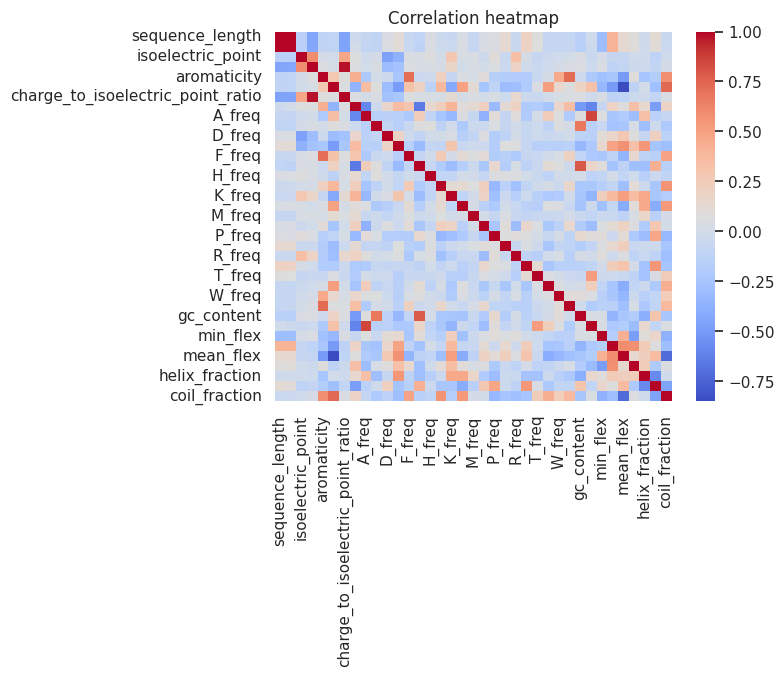

Features with correlation greater than 0.8 :

molecular_weight and sequence_length: 1.00
charge_to_isoelectric_point_ratio and charge_distribution: 0.97
at_content and A_freq: 0.86
mean_flex and hydropathy_index: -0.85


In [145]:
# Compute the correlation matrix
correlation_matrix = X.corr()

sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation heatmap')

plt.show()


# Set a threshold for correlation
threshold = 0.8

# Find pairs of features that have a correlation above the threshold
high_corr = []

# Loop through the upper triangle of the matrix to avoid duplicate pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Print the results
print("Features with correlation greater than", threshold, ":\n")
for feature1, feature2, corr_value in high_corr:
    print(f"{feature1} and {feature2}: {corr_value:.2f}")

The above mean that there is multicollinearity, risk of overfitting and interpretability challenges

---

In [146]:
print(X.dtypes)

sequence_length                        int64
molecular_weight                     float64
isoelectric_point                    float64
charge_distribution                  float64
aromaticity                          float64
hydropathy_index                     float64
charge_to_isoelectric_point_ratio    float64
molecular_weight_per_length          float64
A_freq                               float64
C_freq                               float64
D_freq                               float64
E_freq                               float64
F_freq                               float64
G_freq                               float64
H_freq                               float64
I_freq                               float64
K_freq                               float64
L_freq                               float64
M_freq                               float64
N_freq                               float64
P_freq                               float64
Q_freq                               float64
R_freq    

### Preprocessing

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [148]:
display(X_train.head())
print(X_train.shape)

,sequence_length,molecular_weight,isoelectric_point,charge_distribution,aromaticity,hydropathy_index,charge_to_isoelectric_point_ratio,molecular_weight_per_length,A_freq,C_freq,D_freq,E_freq,F_freq,G_freq,H_freq,I_freq,K_freq,L_freq,M_freq,N_freq,P_freq,Q_freq,R_freq,S_freq,T_freq,V_freq,W_freq,Y_freq,gc_content,at_content,min_flex,max_flex,mean_flex,std_flex,helix_fraction,sheet_fraction,coil_fraction
858,2041,231317.7653,6.568564,-11.301045,0.094072,-0.148506,-1.720474,113.335505,0.068594,0.022048,0.053405,0.060265,0.042626,0.048016,0.024498,0.058795,0.059285,0.114650,0.032337,0.034297,0.055365,0.043116,0.048996,0.075943,0.046056,0.060265,0.013229,0.038217,0.070064,0.114650,0.922464,1.081738,0.997136,0.027061,0.335130,0.267026,0.373836
8509,357,40537.7830,5.090864,-20.273287,0.103641,-0.464426,-3.982288,113.551213,0.081232,0.011204,0.081232,0.064426,0.036415,0.086835,0.042017,0.044818,0.014006,0.086835,0.028011,0.033613,0.044818,0.050420,0.075630,0.056022,0.033613,0.061625,0.028011,0.039216,0.098039,0.114846,0.941631,1.068143,0.996658,0.023412,0.274510,0.302521,0.330532
3127,494,55401.4080,4.525146,-23.760123,0.121457,0.014372,-5.250687,112.148599,0.056680,0.014170,0.064777,0.044534,0.046559,0.058704,0.010121,0.085020,0.034413,0.076923,0.026316,0.046559,0.058704,0.030364,0.028340,0.076923,0.095142,0.070850,0.032389,0.042510,0.072874,0.151822,0.937179,1.056595,0.993487,0.024734,0.238866,0.305668,0.449393
138,754,84115.9992,5.037094,-22.508651,0.072944,-0.379178,-4.468578,111.559681,0.074271,0.002653,0.043767,0.075597,0.047745,0.038462,0.010610,0.061008,0.042440,0.099469,0.023873,0.063660,0.071618,0.067639,0.047745,0.098143,0.054377,0.051724,0.006631,0.018568,0.041114,0.128647,0.940440,1.072583,1.006008,0.025276,0.315650,0.315650,0.339523
3357,602,68417.2238,7.120357,-0.685119,0.134551,-0.264452,-0.096220,113.649873,0.056478,0.016611,0.039867,0.061462,0.069767,0.078073,0.016611,0.051495,0.061462,0.091362,0.021595,0.066445,0.049834,0.033223,0.039867,0.064784,0.061462,0.054817,0.031561,0.033223,0.094684,0.117940,0.919214,1.062071,0.998189,0.027960,0.292359,0.299003,0.393688


(7568, 37)


In [149]:
display(y_train.head())

,label
858,Cyto
8509,Othr
3127,Extr
138,Cyto
3357,Extr


In [150]:
# print the shape
print(eukaryotic_df.shape)

(9460, 39)


Plots

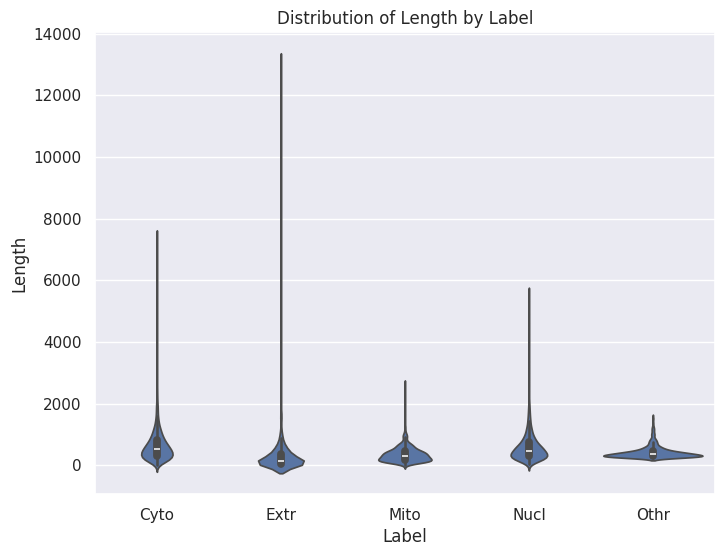

In [151]:
# Distribution of the sequence lenght for each subcellular location
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")  # Optional: Set the plot style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
sns.violinplot(x='label', y='sequence_length', data=eukaryotic_df)
plt.title('Distribution of Length by Label')
plt.xlabel('Label')
plt.ylabel('Length')
plt.show()

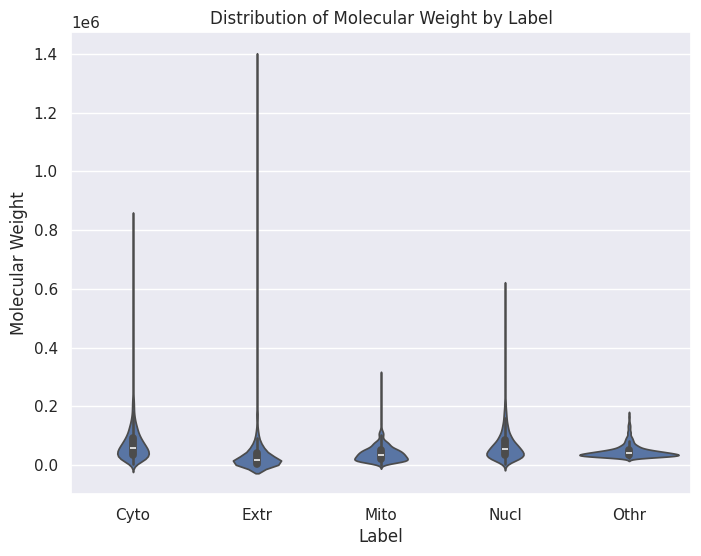

In [152]:
# Distribution of the molecular weight for each subcellular location
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")  # Optional: Set the plot style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
sns.violinplot(x='label', y='molecular_weight', data=eukaryotic_df)
plt.title('Distribution of Molecular Weight by Label')
plt.xlabel('Label')
plt.ylabel('Molecular Weight')
plt.show()

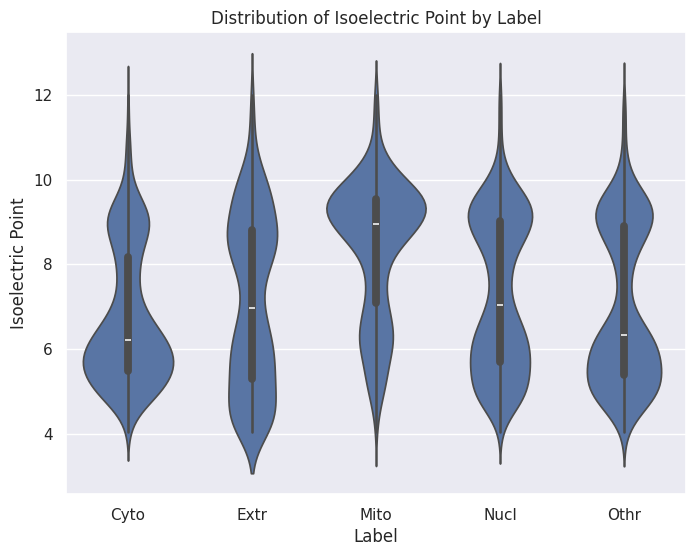

In [153]:
# Distribution of the isoletric points for each subcellular location
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")  # Optional: Set the plot style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
sns.violinplot(x='label', y='isoelectric_point', data=eukaryotic_df)
plt.title('Distribution of Isoelectric Point by Label')
plt.xlabel('Label')
plt.ylabel('Isoelectric Point')
plt.show()

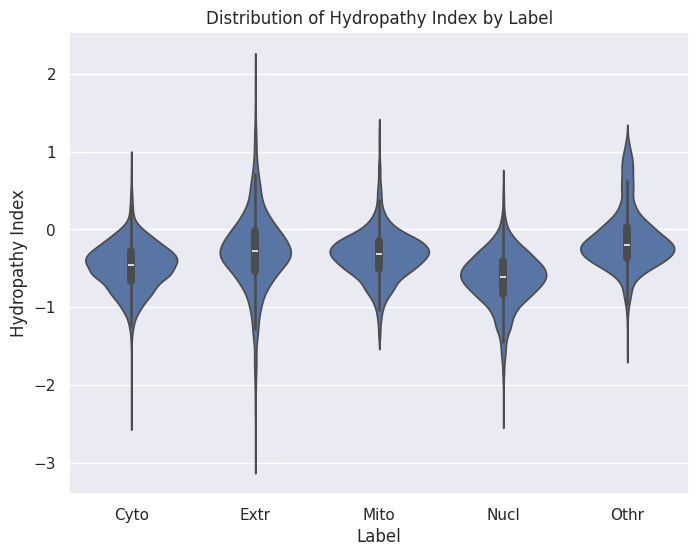

In [154]:
# Distribution of the index of hydrophobycity for each subcellular location
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")  # Optional: Set the plot style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
sns.violinplot(x='label', y='hydropathy_index', data=eukaryotic_df)
plt.title('Distribution of Hydropathy Index by Label')
plt.xlabel('Label')
plt.ylabel('Hydropathy Index')
plt.show()

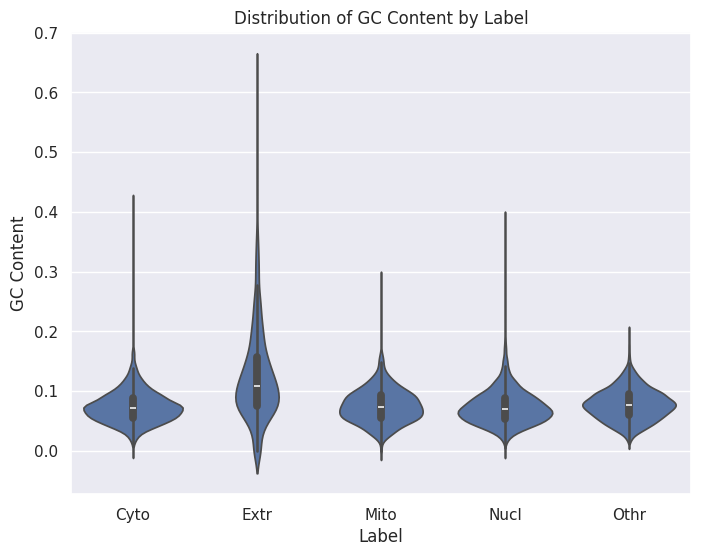

In [155]:
# Distribution of gc and ac content for each subcellular location
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")  # Optional: Set the plot style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
sns.violinplot(x='label', y='gc_content', data=eukaryotic_df)
plt.title('Distribution of GC Content by Label')
plt.xlabel('Label')
plt.ylabel('GC Content')
plt.show()

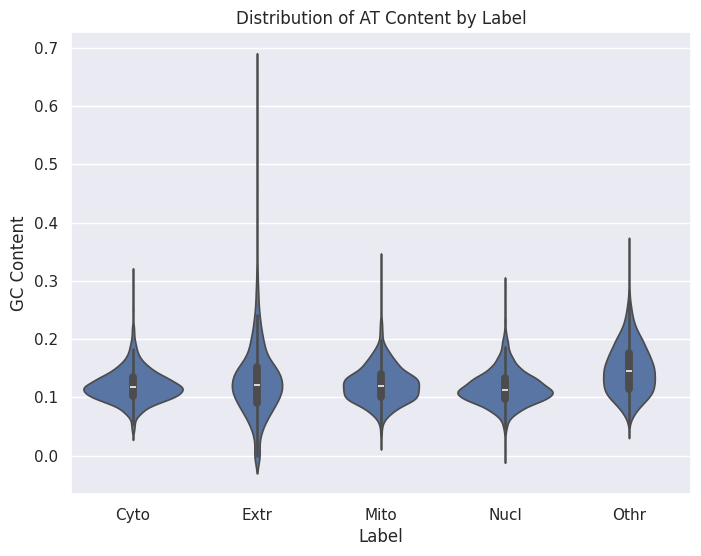

In [156]:
sns.set_theme(style="darkgrid")  # Optional: Set the plot style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
sns.violinplot(x='label', y='at_content', data=eukaryotic_df)
plt.title('Distribution of AT Content by Label')
plt.xlabel('Label')
plt.ylabel('GC Content')
plt.show()

---

Missing values

In [157]:
# Check missing values

missing_values = X_train.isnull().sum()
missing_values_percentage = (missing_values / len(X_train)) * 100

# Order the missing values percentage in ascending order
missing_values_percentage = missing_values_percentage.sort_values(ascending=False)

print("Missing Values percentage in Training Set:")
print(missing_values_percentage)

Missing Values percentage in Training Set:
min_flex                             0.026427
std_flex                             0.026427
mean_flex                            0.026427
max_flex                             0.026427
sequence_length                      0.000000
aromaticity                          0.000000
charge_distribution                  0.000000
isoelectric_point                    0.000000
molecular_weight                     0.000000
hydropathy_index                     0.000000
charge_to_isoelectric_point_ratio    0.000000
molecular_weight_per_length          0.000000
A_freq                               0.000000
G_freq                               0.000000
H_freq                               0.000000
I_freq                               0.000000
K_freq                               0.000000
C_freq                               0.000000
D_freq                               0.000000
E_freq                               0.000000
F_freq                               

---

Save the train and test set in .csv files after dropping columns

In [158]:
# Save the updated training and testing sets to CSV files
X_train.to_csv('./X_train.csv', index=False)
X_test.to_csv('./X_test.csv', index=False)

In [159]:
# Save y_train and y_test to CSV files to retrieve them later if needed
y_train.to_csv('./y_train.csv', index=False)
y_test.to_csv('./y_test.csv', index=False)

---

### Task 3: Design and build a Machine Learning pipeline

In [160]:
# Encoding the target variable
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


print("Transformed y_train:")
display(y_train)
print("Transformed y_test:")
display(y_test)

Transformed y_train:


array([0, 4, 1, ..., 0, 2, 0])

Transformed y_test:


array([3, 4, 3, ..., 0, 2, 3])

Undersampling test

In [161]:
# Apply random undersampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

print(f"Class distribution: {Counter(y_train)}")

# Instantiate the undersampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Fit and transform the training data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print(f"Resampled class distribution: {Counter(y_resampled)}")

Class distribution: Counter({np.int64(3): 2189, np.int64(0): 1970, np.int64(4): 1602, np.int64(1): 989, np.int64(2): 818})
Resampled class distribution: Counter({np.int64(0): 818, np.int64(1): 818, np.int64(2): 818, np.int64(3): 818, np.int64(4): 818})


In [162]:
# Plot the y distribution

#import matplotlib.pyplot as plt
#import seaborn as sns

#sns.set_theme(style="darkgrid")  # Optional: Set the plot style
#plt.figure(figsize=(8, 6))  # Optional: Set the figure size
#sns.countplot(x=y_resampled)
#plt.title('Distribution of Classes')
#plt.xlabel('Label')
#plt.ylabel('Count')
#plt.show()

---

Imports and global variable


In [163]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

RANDOM_STATE = 42

---

In [164]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Creating pipeline that includes preprocessing and model
def make_full_pipeline(model):
    return Pipeline([
        # Since missing values are in min/max/mean/and avg flex features and they have a normal distribustions
        # mean imputation is considered appropriate: https://medium.com/aiskunks/imputation-techniques-for-numerical-features-1331d427fff1
        ("imputer", SimpleImputer(strategy="mean")),
        ('scaler', StandardScaler()),
        ("regressor", model)
    ])


# Hyperparameter optimization function
def optimise_hyperparameters(model, params_dict: dict, X_train: pd.DataFrame, y_train: np.ndarray, scoring: str, cv=5):
    # If cv is an integer, use StratifiedKFold
    if isinstance(cv, int):
        cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    tuner = GridSearchCV(
        make_full_pipeline(model),
        cv=cv,
        param_grid=params_dict,
        n_jobs=-1,
        # F1 Score as a Balanced Metric: To balance the considerations of precision and recall, especially in imbalanced datasets, the F1 score is often preferred. The F1 score is the harmonic mean of precision and recall, providing a single metric that balances both concerns
        scoring=make_scorer(f1_score, average='weighted'),
        error_score='raise'
    )

    return tuner.fit(X_train, y_train)

In [165]:
# SVM with the one-vs-one strategy
# svm_params = {'regressor__C': [0.1, 1, 10], 'regressor__kernel': ['linear', 'rbf'], 'regressor__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]}
# tuned_accuracy_svc = optimise_hyperparameters(SVC(class_weight='balanced', decision_function_shape='ovo', random_state=42), svm_params, X_train, y_train, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

---

In [166]:
# Access metrics results
# svc_results = tuned_accuracy_svc.cv_results_

# Access best estimator
# best_svc_model = tuned_accuracy_svc.best_estimator_

In [167]:
# Best parameters
# print(tuned_accuracy_svc.best_params_)

In [168]:
# Save the model
import joblib

# Save the model to a file
# joblib.dump(best_svc_model, 'best_svc_model.pkl')

---

In [169]:
rf_params = {'regressor__n_estimators': [100, 200, 300], 'regressor__max_depth': [None, 10, 20], 'regressor__min_samples_split': [2, 5, 10]}


In [170]:
# Random Forest C
tuned_rf_clf = optimise_hyperparameters(RandomForestClassifier(), rf_params, X_train, y_train, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
rf_results = tuned_rf_clf.cv_results_
best_rf_model = tuned_rf_clf.best_estimator_

In [171]:
# Access metrics results
rf_results = tuned_rf_clf.cv_results_

# Access best estimator
best_rf_model = tuned_rf_clf.best_estimator_

# Save the model
joblib.dump(best_rf_model, 'best_rf_model.pkl')

['best_rf_model.pkl']

---

First Evaluation On Custom Test Data

In [172]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

# Platt scaling
#calibrated_svm = CalibratedClassifierCV(best_svc_model, cv='prefit', method='sigmoid')
#calibrated_svm.fit(X_train, y_train)

def get_metrics(name: str, model: Pipeline, use_proba: bool = False):
    # Predictions
    y_pred_test = model.predict(X_test)

    if hasattr(model, 'predict_proba'):
        print("Using predict_proba")
        y_proba_test = model.predict_proba(X_test)
    else:
        # Handle cases where predict_proba is not available
        y_proba_test = model.decision_function(X_test)


    # Compute classification metrics
    metrics_test = {
        "Model": name,
        "Accuracy": balanced_accuracy_score(y_test, y_pred_test),
        "Precision": precision_score(y_test, y_pred_test, average='weighted'),
        "Recall": recall_score(y_test, y_pred_test, average='weighted'),
        "F1-score": f1_score(y_test, y_pred_test, average='weighted'),
        "AUC": roc_auc_score(y_test, y_proba_test, multi_class='ovo', average='weighted') if y_proba_test is not None else 'N/A',
    }

    return metrics_test

results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"])
# results_df.loc[0] = get_metrics("SVC", calibrated_svm)
results_df.loc[1] = get_metrics("Random Forest", best_rf_model)

Using predict_proba


In [173]:
results_df

,Model,Accuracy,Precision,Recall,F1-score,AUC
1,Random Forest,0.649322,0.658622,0.662262,0.657753,0.888307


---

In [174]:
# prompt: Access hyperparameters from .pkl file

import joblib

# Load the saved model
loaded_model = joblib.load('best_rf_model.pkl')

# Access the hyperparameters of the best estimator
best_params = loaded_model.named_steps['regressor'].get_params()

# Print the hyperparameters
print("Best hyperparameters:")
for param_name, param_value in best_params.items():
  print(f"{param_name}: {param_value}")




Best hyperparameters:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 200
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


---

Plot confusion matrix and AUC and sensitivity plots

['Cyto' 'Extr' 'Mito' 'Nucl' 'Othr']


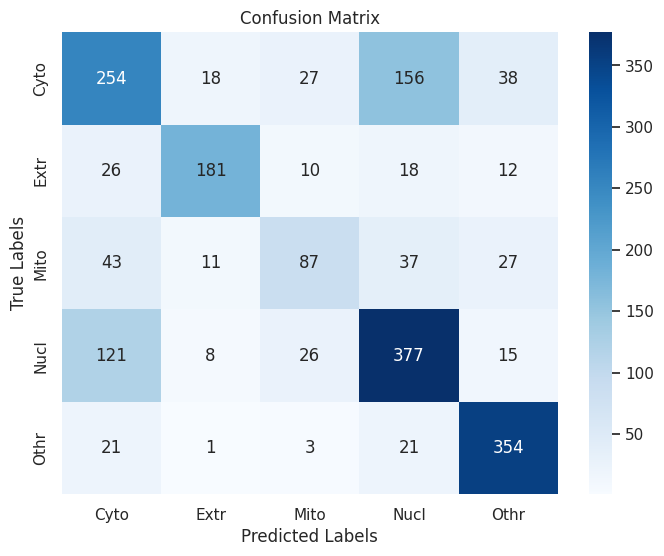

In [175]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score
import seaborn as sns

# Load your model
model = joblib.load('best_rf_model.pkl')


y_pred = model.predict(X_test)

# The order of labels in this array corresponds to the numerical values assigned to them (0, 1, 2, 3, 4, respectively, in this example).
original_labels = label_encoder.classes_
print(original_labels)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cyto', 'Extr', 'Mito', 'Nucl' ,'Othr'], yticklabels=['Cyto', 'Extr', 'Mito', 'Nucl', 'Othr'])
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()


---

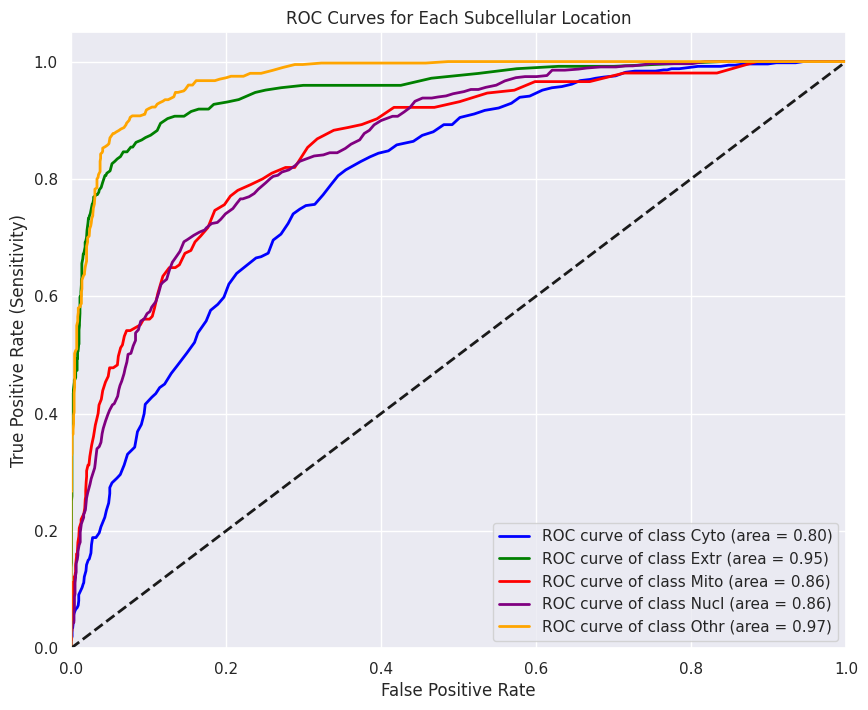

In [176]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Load your model
model = joblib.load('best_rf_model.pkl')

y_pred = model.predict(X_test)


# Binarize the output for multi-class ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], model.predict_proba(X_test)[:, i])

# Plot ROC curves for all classes
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Adjust colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {original_labels[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random performance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for Each Subcellular Location')
plt.legend(loc="lower right")
plt.show()

---

### Model interpretation

Relative importance of the best model

In [177]:
# RF
import matplotlib.pyplot as plt

rf_model = best_rf_model.named_steps['regressor']
importances_rf = rf_model.feature_importances_

feature_names = X_train.columns.tolist()

# Combine the importances with the feature names
feature_importances = pd.Series(importances_rf, index=feature_names)


top_10_features = feature_importances.nlargest(25)

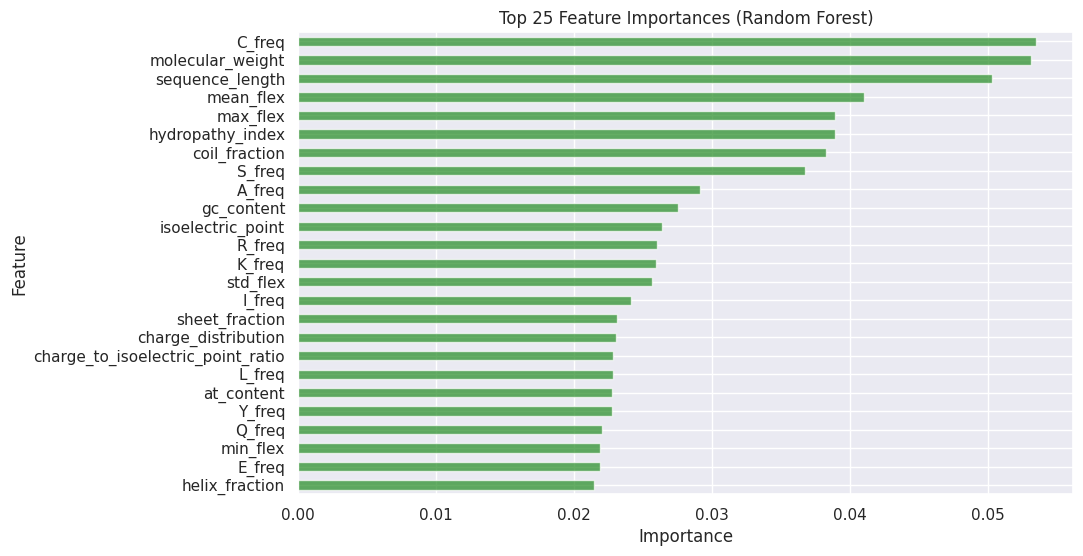

In [178]:
# Plot the top 10 features
plt.figure(figsize=(10, 6))
top_10_features.sort_values().plot.barh(color="forestgreen", alpha=0.7)
plt.title("Top 25 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

---

Blindtest

In [179]:
import pandas as pd

# Define blin labels for each SEQ ID (as provided in the CW description)
labels = {
    "SEQ01": "Nucl",
    "SEQ02": "Othr",
    "SEQ03": "Extr",
    "SEQ04": "Mito",
    "SEQ05": "Cyto",
    "SEQ06": "Nucl",
    "SEQ07": "Othr",
    "SEQ08": "Extr",
    "SEQ09": "Mito",
    "SEQ10": "Cyto",
    "SEQ11": "Nucl",
    "SEQ12": "Othr",
    "SEQ13": "Extr",
    "SEQ14": "Mito",
    "SEQ15": "Cyto",
    "SEQ16": "Nucl",
    "SEQ17": "Othr",
    "SEQ18": "Extr",
    "SEQ19": "Mito",
    "SEQ20": "Cyto"
}

# Create a DataFrame from the labels dictionary
df = pd.DataFrame(list(labels.items()), columns=['SeqID', 'label'])
df.to_csv("seqid_class_mapping.csv", index=False)


In [180]:
display(df)

,SeqID,label
0,SEQ01,Nucl
1,SEQ02,Othr
2,SEQ03,Extr
3,SEQ04,Mito
4,SEQ05,Cyto
5,SEQ06,Nucl
6,SEQ07,Othr
7,SEQ08,Extr
8,SEQ09,Mito
9,SEQ10,Cyto


In [181]:
y_blindtest = df['label']

In [182]:

# Use the same fitted for training data
y_blindtest = label_encoder.transform(y_blindtest)

print("Transformed y_blindtest:")
display(y_blindtest)

Transformed y_blindtest:


array([3, 4, 1, 2, 0, 3, 4, 1, 2, 0, 3, 4, 1, 2, 0, 3, 4, 1, 2, 0])

In [183]:
def load_blind_file_assign_class(fasta_file_path, print_data=False):


    # Parse the FASTA file
    records = SeqIO.parse(fasta_file_path, "fasta")
    sequences = []

    for record in records:
        sequences.append((record.id, record.seq))

    return sequences

In [184]:
blindtest = load_blind_file_assign_class('blind.fasta')

In [185]:
import pandas as pd


blindtest_data = []


for record in blindtest:
    id, seq = record
    seq = seq.replace('X', '').replace('U', '').replace('B', '')
    #Explain your choices, giving references.

    features = {
        'SeqID': id,
        'sequence_length': len(seq),
        'sequence': str(seq),
        'molecular_weight': ProteinAnalysis(str(seq)).molecular_weight(),
        'isoelectric_point': ProteinAnalysis(str(seq)).isoelectric_point(),
        'charge_distribution': ProteinAnalysis(str(seq)).charge_at_pH(7.4),
        'aromaticity': ProteinAnalysis(str(seq)).aromaticity(),
        'flexibility': ProteinAnalysis(str(seq)).flexibility(), # check ref https://onlinelibrary.wiley.com/doi/abs/10.1002/prot.340190203
        'secondary_structure_fraction': ProteinAnalysis(str(seq)).secondary_structure_fraction(),
        'hydropathy_index': ProtParam.ProteinAnalysis(str(seq)).gravy(),
        'charge_to_isoelectric_point_ratio': ProteinAnalysis(str(seq)).charge_at_pH(7.4) / ProteinAnalysis(str(seq)).isoelectric_point(),
        'molecular_weight_per_length' : ProteinAnalysis(str(seq)).molecular_weight() / len(seq)
        }

    # Amino acid frequency features
    aa_frequencies = amino_acid_frequencies(seq)
    for aa, freq in aa_frequencies.items():
      features[f'{aa}_freq'] = freq

    # GC content
    gc_content, at_content = sequence_length_at_gc_content(seq)
    features['gc_content'] = gc_content
    features['at_content'] = at_content


    blindtest_data.append(features)

blindtest_data = pd.DataFrame(blindtest_data)

In [186]:
# Add additional features

# 1. Flexibility Stats
flexibility_stats = blindtest_data['flexibility'].apply(compute_flexibility_stats)
blindtest_data = pd.concat([blindtest_data, flexibility_stats], axis=1)
blindtest_data.drop(columns=['flexibility'], inplace=True)

# 2. Secondary Structure Fraction
blindtest_data[['helix_fraction', 'sheet_fraction', 'coil_fraction']] = pd.DataFrame(blindtest_data['secondary_structure_fraction'].tolist(), index=blindtest_data.index)
blindtest_data.drop(columns=['secondary_structure_fraction'], inplace=True)


blindtest_data = pd.DataFrame(blindtest_data)

In [187]:
import joblib

# Load the trained RF model
rf_model = joblib.load("best_rf_model.pkl")


In [188]:
blindtest_data.drop(columns=['sequence'], inplace=True)
blindtest_data.drop(columns=['SeqID'], inplace=True)

In [189]:
# Assuming `X_test` is the preprocessed feature matrix for the test set
predictions = rf_model.predict(blindtest_data)
display(predictions.shape
        )

display(predictions)

(20,)

array([2, 4, 3, 0, 0, 0, 1, 4, 1, 2, 0, 3, 3, 3, 4, 3, 4, 3, 4, 4])

In [190]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_blindtest, predictions))
print("Classification Report:")
print(classification_report(y_blindtest, predictions))


Accuracy: 0.2
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.25      0.25         4
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.17      0.25      0.20         4
           4       0.33      0.50      0.40         4

    accuracy                           0.20        20
   macro avg       0.15      0.20      0.17        20
weighted avg       0.15      0.20      0.17        20



In [191]:
# env connected cell
# infinte loop

for i in range(20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000):
  continue

KeyboardInterrupt: 